In [1]:
import numpy as np
import pandas as pd

In [3]:
# Load the Excel file
file_path = 'ICT.xlsx'  # Update this path to your actual file location
xls = pd.ExcelFile(file_path)

# Load both sheets for morning and afternoon sessions
morning_data = pd.read_excel(xls, sheet_name='ICT Morning', header=None)
afternoon_data = pd.read_excel(xls, sheet_name='ICT Afternoon', header=None)

# Fill NaN with zeros assuming missing values mean no attempt was made for that activity
morning_data.fillna(0, inplace=True)
afternoon_data.fillna(0, inplace=True)
df = morning_data.copy()
df = df.iloc[:, 3:]
df.iloc[1, -1] = 'Total'

In [4]:
# Extract weights (first row) and convert to a numeric series
weights = pd.to_numeric(df.iloc[0]).tolist()

# Extract total marks (third row) and convert to a numeric series
total_marks = pd.to_numeric(df.iloc[2]).tolist()

In [5]:
# Set the second row (activity names) as the DataFrame header
df.columns = df.iloc[1]

# Drop the rows that are not needed for student marks calculation
df = df.drop([0, 1, 2])


In [6]:
# Normalize the marks
normalized_marks = df.div(total_marks) * weights

# Print the first few rows of the normalized marks to verify
normalized_marks.to_csv('ICT(Morning)_Cleaned.csv', index=False)

In [8]:
import pandas as pd

# Load the Excel file
file_path = 'ICT.xlsx'  # Update this path to your actual file location
xls = pd.ExcelFile(file_path)

# Load both sheets for morning and afternoon sessions
morning_data = pd.read_excel(xls, sheet_name='ICT Morning', header=None)
afternoon_data = pd.read_excel(xls, sheet_name='ICT Afternoon', header=None)

# Fill NaN with zeros assuming missing values mean no attempt was made for that activity
morning_data.fillna(0, inplace=True)
afternoon_data.fillna(0, inplace=True)

# Create a copy of afternoon_data to work with
df_afternoon = afternoon_data.copy()

# Exclude the first three columns and change the last element of the second row to 'Total'
df_afternoon = df_afternoon.iloc[:, 3:]
df_afternoon.iloc[1, -1] = 'Total'

# Extract weights (first row) and convert to a numeric series
weights_afternoon = pd.to_numeric(df_afternoon.iloc[0]).tolist()

# Extract total marks (third row) and convert to a numeric series
total_marks_afternoon = pd.to_numeric(df_afternoon.iloc[2]).tolist()

# Set the second row (activity names) as the DataFrame header
df_afternoon.columns = df_afternoon.iloc[1]

# Drop the rows that are not needed for student marks calculation
df_afternoon = df_afternoon.drop([0, 1, 2])

# Normalize the marks
normalized_marks_afternoon = df_afternoon.div(total_marks_afternoon) * weights_afternoon

# Print the first few rows of the normalized marks to verify
normalized_marks_afternoon.to_csv('ICT(Afternoon)_Cleaned.csv', index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Load data
df_train = pd.read_csv('ICT(Morning)_Cleaned.csv')
df_test = pd.read_csv('ICT(Afternoon)_Cleaned.csv')

In [10]:
# Generate Student IDs
df_test['Student ID'] = ['S' + str(i+1) for i in range(len(df_test))]
df_train['Student ID'] = ['S' + str(i+1) for i in range(len(df_train))]

In [21]:
# List of activities incrementally included in the models
activities = [col for col in df_train.columns if col not in ['Student ID', 'Total','Final']]
activities

['Q1', 'Q2', 'A1', 'Q3', 'Q4', 'Midterm', 'Q5', 'A2', 'Q6', 'Q7', 'Q8']

In [12]:
# Find the index of 'Mid' in the activities list
mid_index = activities.index('Midterm')

In [13]:
# Models and their hyperparameters
model_params = {
    'Ridge': {'model': Ridge(), 'params': {'alpha': [0.01, 0.1, 1, 10, 100, 1000],'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],'fit_intercept':[True,False]}},
    'LinearRegression': {'model': LinearRegression(), 'params': {}}
}


In [14]:
results_df = pd.DataFrame()
results_df['Actual Total'] = df_test['Total']
errors_df = pd.DataFrame(df_test['Student ID'], columns=['Student ID'])


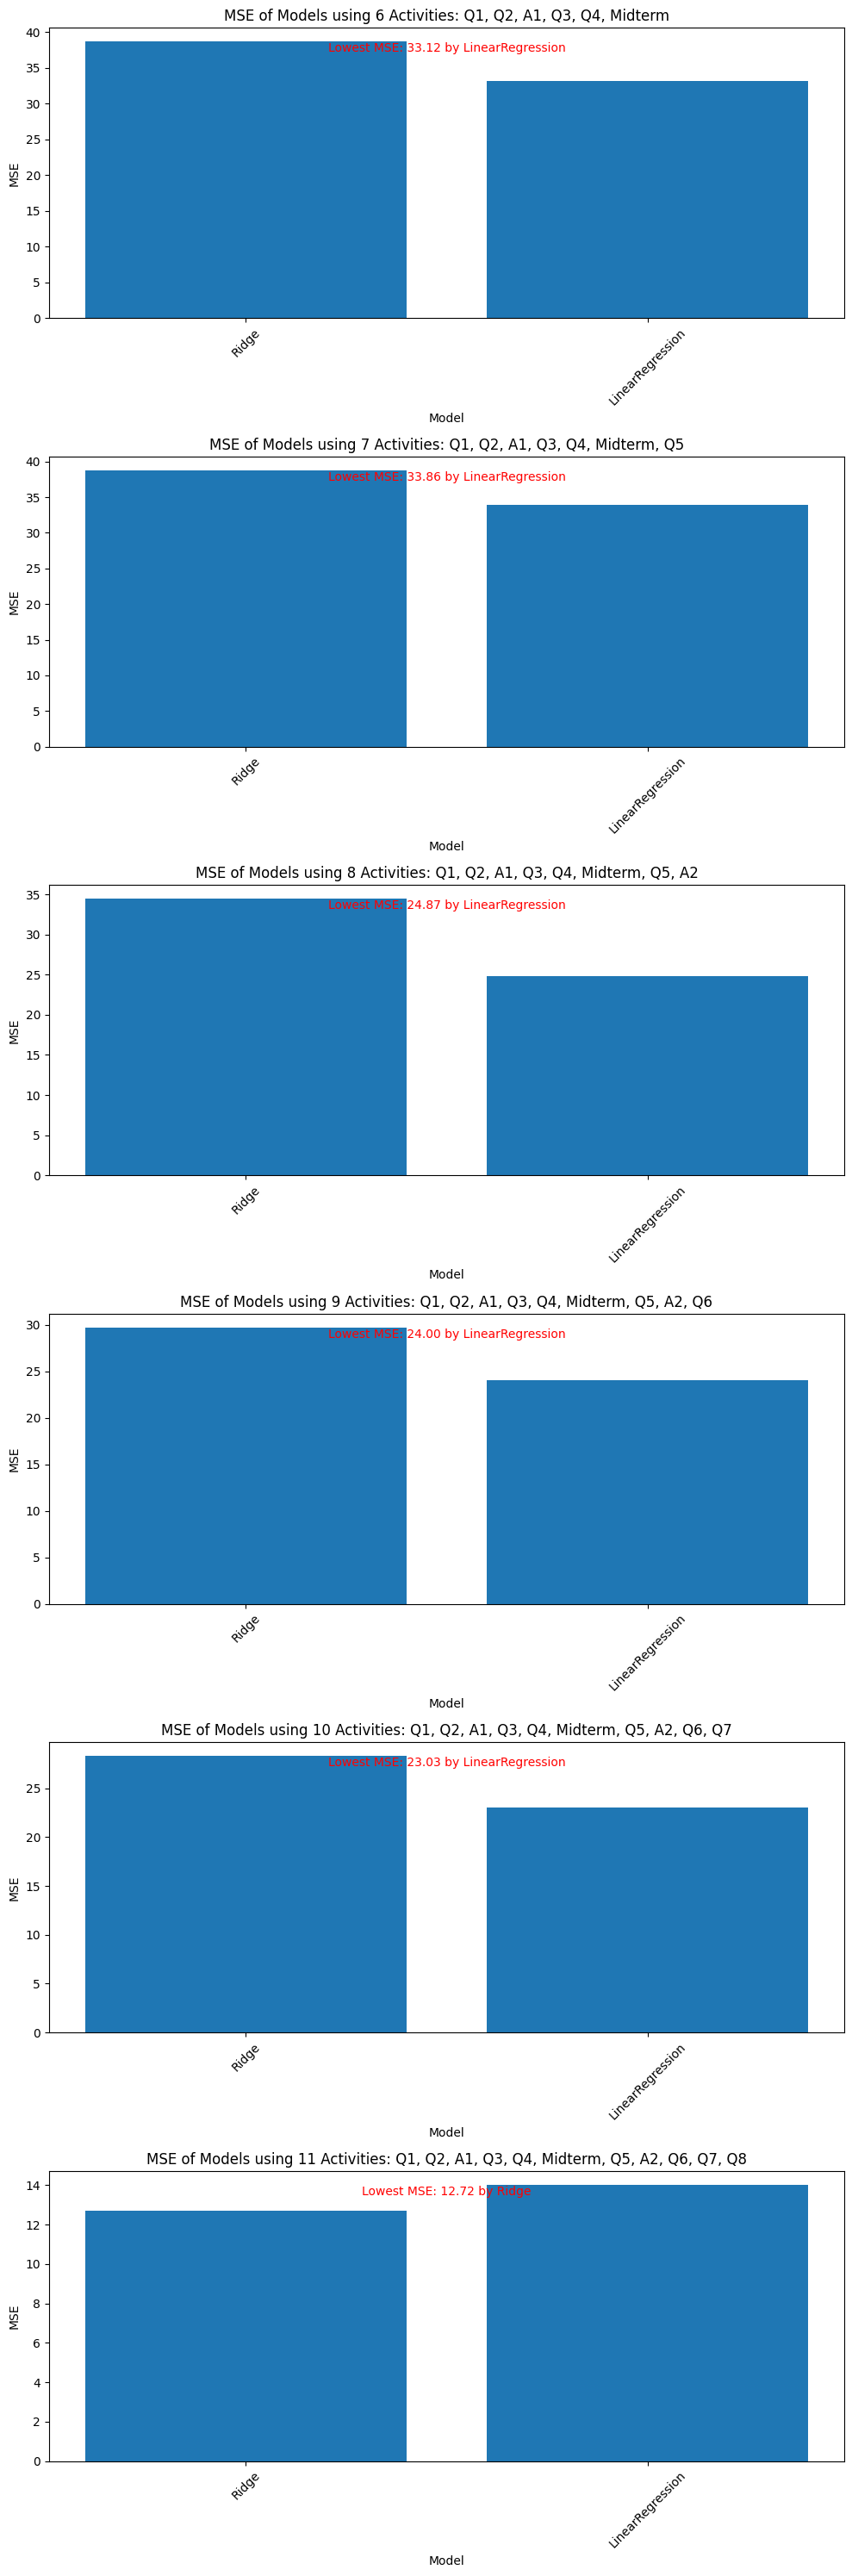

In [22]:
# Prepare to plot MSE comparisons
fig, axes = plt.subplots(nrows=len(activities) - mid_index, ncols=1, figsize=(10, 5 * (len(activities) - mid_index)))

# Store MSE for plotting and errors information
mse_values = []
all_abs_errors = []

# Train models incrementally on the sets of activities
for i in range(mid_index, len(activities)):
    current_activities = activities[:i+1]
    X_train = df_train[current_activities]
    y_train = df_train['Total']
    X_test = df_test[current_activities]
    y_test = df_test['Total']

    mses = []
    model_names = []
    min_mse = float('inf')
    best_model = None
    best_pred = None

    # Train and evaluate each model
    for model_name, mp in model_params.items():
        clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mses.append(mse)
        model_names.append(model_name)
        if mse < min_mse:
            min_mse = mse
            best_model = model_name
            best_pred = y_pred

    # Update results with the best model predictions
    predicted_column_name = f'Predicted Total after {", ".join(current_activities)}'
    results_df[predicted_column_name] = best_pred
    abs_errors = abs(y_test - best_pred)
    all_abs_errors.append(abs_errors)

    # Plotting the MSE for each model
    ax = axes[i - mid_index]
    ax.bar(model_names, mses)
    ax.set_title(f'MSE of Models using {i+1} Activities: {", ".join(current_activities)}')
    ax.annotate(f'Lowest MSE: {min_mse:.2f} by {best_model}', (0.5, 0.95), xycoords='axes fraction', ha='center', va='top', color='red')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Model')
    ax.set_xticklabels(model_names, rotation=45)

# Create the errors dataframe for CSV output
errors_df['Avg Absolute Error'] = pd.concat(all_abs_errors, axis=1).mean(axis=1)
errors_df['Min Absolute Error'] = pd.concat(all_abs_errors, axis=1).min(axis=1)
errors_df['Max Absolute Error'] = pd.concat(all_abs_errors, axis=1).max(axis=1)

# Save the results to Excel and CSV files
results_df.to_excel('predicted_totals_incremental.xlsx', index=False)
errors_df.to_csv('error_stats.csv', index=False)

plt.tight_layout()
plt.show()